# Setup

In [1]:
import langchain as lc
print("LangChain version:", lc.__version__)
!python -V

LangChain version: 1.2.6
Python 3.11.0


In [2]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

llm = HuggingFaceEndpoint(
    repo_id="meta-llama/Llama-3.1-8B-Instruct",
    task="text-generation",
    max_new_tokens=512,
    temperature=0.1,
)
chat_llm = ChatHuggingFace(llm=llm)

# LCEL Syntax

In [3]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompt = ChatPromptTemplate([
    "Give me small report about {topic}"
]
)

lcel_chain = prompt | chat_llm | StrOutputParser()

# and run
out = lcel_chain.invoke({"topic": "Artificial Intelligence"})
print(out)

**Artificial Intelligence Report**

**Introduction**

Artificial Intelligence (AI) is a rapidly growing field that involves the development of computer systems that can perform tasks that typically require human intelligence, such as learning, problem-solving, and decision-making. AI has the potential to revolutionize various industries, including healthcare, finance, transportation, and education.

**Key Areas of AI**

1. **Machine Learning (ML)**: A subset of AI that involves the development of algorithms that enable machines to learn from data and improve their performance over time.
2. **Natural Language Processing (NLP)**: A field of AI that focuses on the interaction between computers and humans through natural language.
3. **Computer Vision**: A field of AI that involves the development of algorithms that enable computers to interpret and understand visual data from images and videos.
4. **Robotics**: A field of AI that involves the development of robots that can perform tasks t

## How the Pipe Operator Works

In [4]:
class Runnable:
    def __init__(self, func):
        self.func = func

    def __or__(self, other):
        def chained_func(*args, **kwargs):
            # the other func consumes the result of this func
            return other(self.func(*args, **kwargs))
        return Runnable(chained_func)

    def __call__(self, *args, **kwargs):
        return self.func(*args, **kwargs)

In [5]:
def add_five(x):
    return x + 5

def multiply_by_two(x):
    return x * 2

# wrap the functions with Runnable
add_five = Runnable(add_five)
multiply_by_two = Runnable(multiply_by_two)

# run them using the object approach
chain = add_five.__or__(multiply_by_two)
chain(3)  # should return 16

16

In [6]:
# chain the runnable functions together
chain = add_five | multiply_by_two

# invoke the chain
chain(3)  # we should return 16

16

## LCEL Deep Dive

### Runnables

In [7]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

prompt = "Represent this sentence for searching relevant passages: "
model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
query_encode_kwargs = {"prompt": prompt}

embed = HuggingFaceEmbeddings(
    model_name=model_name, 
    model_kwargs=model_kwargs, 
    encode_kwargs=encode_kwargs,
    query_encode_kwargs=query_encode_kwargs
)

vecstore_a = InMemoryVectorStore.from_texts(
    ["half the info will be here", "James' birthday is the 7th December"],
    embedding=embed
)
vecstore_b = InMemoryVectorStore.from_texts(
    ["and half here", "James was born in 1994"],
    embedding=embed
)

2026-02-26 08:55:41.135303: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
from langchain_core.runnables import (
    RunnableParallel,
    RunnablePassthrough
)

retriever_a = vecstore_a.as_retriever()
retriever_b = vecstore_b.as_retriever()

prompt_str = """Answer the question below using the context:

Context: {context}

Question: {question}

Answer: """

prompt = ChatPromptTemplate.from_template(prompt_str)

retrieval = RunnableParallel(
    {"context": retriever_a, "question": RunnablePassthrough()}
)

chain = retrieval | prompt | chat_llm | StrOutputParser()

In [9]:
out = chain.invoke("when was James born?")
print(out)

The 7th December.


In [10]:
prompt_str = """Answer the question below using the context:

Context:
{context_a}
{context_b}

Question: {question}

Answer: """
prompt = ChatPromptTemplate.from_template(prompt_str)

retrieval = RunnableParallel(
    {
        "context_a": retriever_a, "context_b": retriever_b,
        "question": RunnablePassthrough()
    }
)

chain = retrieval | prompt | chat_llm | StrOutputParser()

In [11]:
out = chain.invoke("when was James born?")
print(out)

James was born in 1994.


### Runnable Lambdas

In [12]:
from langchain_core.runnables import RunnableLambda

# wrap the functions with RunnableLambda
add_five = RunnableLambda(add_five)
multiply_by_two = RunnableLambda(multiply_by_two)

In [13]:
chain = add_five | multiply_by_two

In [14]:
chain.invoke(3)

16

In [15]:
prompt_str = "Tell me an short fact about {topic}"

prompt = ChatPromptTemplate.from_template(prompt_str)

chain = prompt | chat_llm | StrOutputParser()

In [16]:
chain.invoke({"topic": "Artificial Intelligence"})

"Here's a short fact about Artificial Intelligence:\n\nThe first AI program, called Logical Theorist, was developed in 1956 by Allen Newell and Herbert Simon. It was designed to simulate human problem-solving abilities and was able to reason and solve problems using logical deductions."

In [17]:
def extract_fact(x):
    if "\n\n" in x:
        return "\n".join(x.split("\n\n")[1:])
    else:
        return x
    
get_fact = RunnableLambda(extract_fact)

chain = prompt | chat_llm | StrOutputParser() | get_fact

In [18]:
chain.invoke({"topic": "Artificial Intelligence"})

'The first AI program, called Logical Theorist, was developed in 1956 by Allen Newell and Herbert Simon. It was designed to simulate human problem-solving abilities and was able to reason and solve problems using logical deductions.'

# Chunking

## Preparing Data

In [19]:
print("Downloading the documentation for offline use...")
!wget -r -A.html -P rtdocs https://langchain-doc.readthedocs.io/en/latest/

In [20]:
from langchain_community.document_loaders import ReadTheDocsLoader

loader = ReadTheDocsLoader('rtdocs')
docs = loader.load()
len(docs)

367

In [21]:
docs[5].page_content

'.md\nGlossary\n Contents \nChain of Thought Prompting\nAction Plan Generation\nReAct Prompting\nSelf-ask\nPrompt Chaining\nMemetic Proxy\nSelf Consistency\nInception\nMemPrompt\nGlossary#\nThis is a collection of terminology commonly used when developing LLM applications.\nIt contains reference to external papers or sources where the concept was first introduced,\nas well as to places in LangChain where the concept is used.\nChain of Thought Prompting#\nA prompting technique used to encourage the model to generate a series of intermediate reasoning steps.\nA less formal way to induce this behavior is to include “Let’s think step-by-step” in the prompt.\nResources:\nChain-of-Thought Paper\nStep-by-Step Paper\nAction Plan Generation#\nA prompt usage that uses a language model to generate actions to take.\nThe results of these actions can then be fed back into the language model to generate a subsequent action.\nResources:\nWebGPT Paper\nSayCan Paper\nReAct Prompting#\nA prompting techni

In [22]:
docs[5].metadata['source'].replace('rtdocs/', 'https://')

'https://langchain-doc.readthedocs.io/en/latest/glossary.html'

## Token Analysis of the data

In [23]:
import tiktoken

# We use gpt-4.1-mini as standard but tiktoken does not support gpt-4.1.
# Fortunately, 4.1 and 4o models all use the same underlying tokenizer and so
# we can use gpt-4o here
tokenizer = tiktoken.encoding_for_model('gpt-4o')

# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

In [24]:
token_counts = [tiktoken_len(doc.page_content) for doc in docs]

In [25]:
print(f"""Min: {min(token_counts)}
Avg: {int(sum(token_counts) / len(token_counts))}
Max: {max(token_counts)}""")

Min: 16
Avg: 1289
Max: 57241


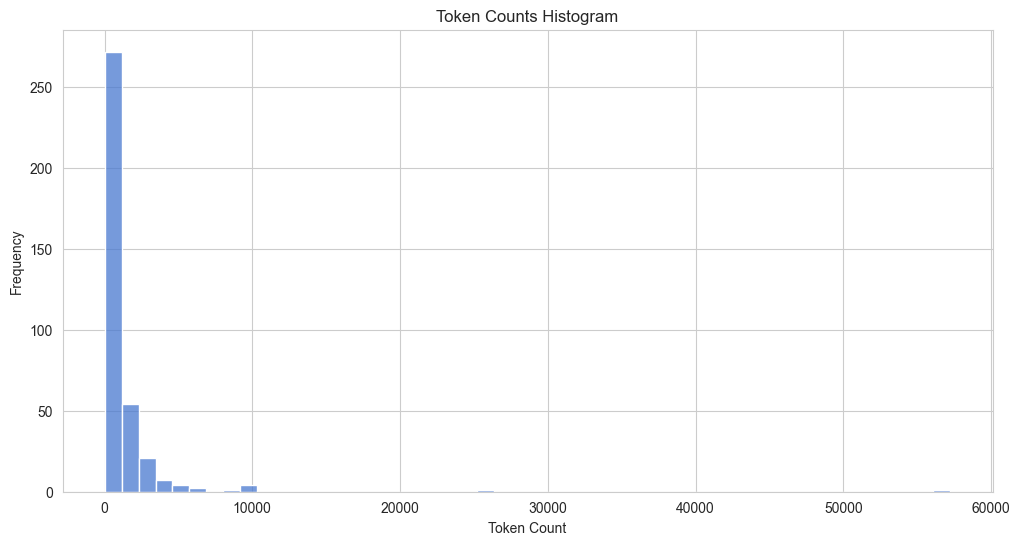

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# set style and color palette for the plot
sns.set_style("whitegrid")
sns.set_palette("muted")

# create histogram
plt.figure(figsize=(12, 6))
sns.histplot(token_counts, kde=False, bins=50)

# customize the plot info
plt.title("Token Counts Histogram")
plt.xlabel("Token Count")
plt.ylabel("Frequency")

plt.show()

## Chunking the data

In [27]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=20,  # number of tokens overlap between chunks
    length_function=tiktoken_len,
    separators=['\n\n', '\n', ' ', '']
)

In [28]:
chunks = text_splitter.split_text(docs[5].page_content)
len(chunks)

2

In [29]:
tiktoken_len(chunks[0]), tiktoken_len(chunks[1]), tiktoken_len(docs[5].page_content)

(340, 233, 556)

In [30]:
import hashlib
m = hashlib.md5()  # this will convert URL into unique ID

url = docs[5].metadata['source'].replace('rtdocs/', 'https://')
print(url)

# convert URL to unique ID
m.update(url.encode('utf-8'))
uid = m.hexdigest()[:12]
print(uid)

https://langchain-doc.readthedocs.io/en/latest/glossary.html
f9be197bab30


In [31]:
data = [
    {
        'id': f'{uid}-{i}',
        'text': chunk,
        'source': url
    } for i, chunk in enumerate(chunks)
]
data

[{'id': 'f9be197bab30-0',
  'text': '.md\nGlossary\n Contents \nChain of Thought Prompting\nAction Plan Generation\nReAct Prompting\nSelf-ask\nPrompt Chaining\nMemetic Proxy\nSelf Consistency\nInception\nMemPrompt\nGlossary#\nThis is a collection of terminology commonly used when developing LLM applications.\nIt contains reference to external papers or sources where the concept was first introduced,\nas well as to places in LangChain where the concept is used.\nChain of Thought Prompting#\nA prompting technique used to encourage the model to generate a series of intermediate reasoning steps.\nA less formal way to induce this behavior is to include “Let’s think step-by-step” in the prompt.\nResources:\nChain-of-Thought Paper\nStep-by-Step Paper\nAction Plan Generation#\nA prompt usage that uses a language model to generate actions to take.\nThe results of these actions can then be fed back into the language model to generate a subsequent action.\nResources:\nWebGPT Paper\nSayCan Paper\n

In [32]:
from tqdm.auto import tqdm

documents = []

for doc in tqdm(docs):
    url = doc.metadata['source'].replace('rtdocs/', 'https://')
    m.update(url.encode('utf-8'))
    uid = m.hexdigest()[:12]
    chunks = text_splitter.split_text(doc.page_content)
    for i, chunk in enumerate(chunks):
        documents.append({
            'id': f'{uid}-{i}',
            'text': chunk,
            'source': url
        })

len(documents)

  0%|          | 0/367 [00:00<?, ?it/s]

1959

In [33]:
import json

with open('train.jsonl', 'w') as f:
    for doc in documents:
        f.write(json.dumps(doc) + '\n')

In [34]:
documents = []

with open('train.jsonl', 'r') as f:
    for line in f:
        documents.append(json.loads(line))

len(documents)

1959

In [35]:
documents[0]

{'id': '264a737d1eb0-0',
 'text': '.rst\nWelcome to LangChain\n Contents \nGetting Started\nModules\nUse Cases\nReference Docs\nLangChain Ecosystem\nAdditional Resources\nWelcome to LangChain#\nLarge language models (LLMs) are emerging as a transformative technology, enabling\ndevelopers to build applications that they previously could not.\nBut using these LLMs in isolation is often not enough to\ncreate a truly powerful app - the real power comes when you are able to\ncombine them with other sources of computation or knowledge.\nThis library is aimed at assisting in the development of those types of applications. Common examples of these types of applications include:\n❓ Question Answering over specific documents\nDocumentation\nEnd-to-end Example: Question Answering over Notion Database\n💬 Chatbots\nDocumentation\nEnd-to-end Example: Chat-LangChain\n🤖 Agents\nDocumentation\nEnd-to-end Example: GPT+WolframAlpha\nGetting Started#\nCheckout the below guide for a walkthrough of how to g

# Streaming

Instead of waiting for the full response, streaming yields tokens as they are generated. LangChain chat models expose a `.stream()` method that returns an iterator of `AIMessageChunk` objects — each chunk carries a partial `content` string that you can print immediately.

In [36]:
# Basic streaming with the chat model directly
for chunk in chat_llm.stream("Tell me a short story about a robot learning to paint."):
    print(chunk.content, end="", flush=True)
print()  # newline after stream finishes

In a small, cluttered art studio, a team of engineers had been working on a top-secret project: a robot designed to learn the art of painting. They called it "Aurora," after the breathtaking beauty of the aurora borealis.

Aurora was a sleek, silver robot with a long, slender arm and a delicate hand. Its creators had equipped it with advanced sensors and algorithms that would allow it to learn and adapt to different painting techniques.

The team's leader, a brilliant artist and engineer named Dr. Rachel Kim, stood before Aurora and explained the task at hand. "Aurora, we want you to learn to paint like a human. We'll start with simple exercises, and gradually increase the complexity of the tasks."

Aurora's bright, blue eyes sparkled with curiosity as it nodded its head. The robot's advanced sensors began to scan the studio, taking in the colors, textures, and shapes of the surrounding environment.

The first exercise was to create a simple still life. Dr. Kim placed a vase, a few flo

In [37]:
# Streaming through an LCEL chain — the StrOutputParser unwraps the chunk content automatically
stream_chain = prompt | chat_llm | StrOutputParser()

for token in stream_chain.stream({"topic": "quantum computing"}):
    print(token, end="", flush=True)
print()

Here's a short fact about quantum computing:

Quantum computers can solve certain problems much faster than classical computers due to a phenomenon called "quantum parallelism." This means that a single quantum bit (qubit) can exist in multiple states simultaneously, allowing a quantum computer to process many possibilities at the same time, whereas a classical computer would have to process each possibility one by one.


In [38]:
# Collect streamed tokens into a full response while printing in real-time
full_response = []

for token in stream_chain.stream({"topic": "the history of the internet"}):
    print(token, end="", flush=True)
    full_response.append(token)

print("\n\n--- Full response ---")
print("".join(full_response))

One interesting fact about the history of the internet is that the first message sent over the internet was "LO" (short for "LOL" or "Laugh Out Loud") but it was later completed to "LOL" by the sender.

--- Full response ---
One interesting fact about the history of the internet is that the first message sent over the internet was "LO" (short for "LOL" or "Laugh Out Loud") but it was later completed to "LOL" by the sender.
